In [1]:
import os
import numpy as np
import pandas as pd
import glob
import random
from server_utils import get_binary_labels, get_selected_channel_idxes, extract_emotion_psd_features, train_emotion_classifier

# 参数设置
fs = 250
subject_id = 2  # 修改为当前受试者编号
base_data_path = f"/mnt/dataset0/xkp/closed-loop/server/data/sub{subject_id}"
eeg_folders = ["pre_eeg_1", "pre_eeg_2"]  # 要加载的所有预实验数据文件夹

# 存储所有实验数据
all_eeg_data = []
all_labels = []

# 从每个实验文件夹加载数据
for folder in eeg_folders:
    folder_path = os.path.join(base_data_path, folder)
    
    if not os.path.exists(folder_path):
        print(f"警告: 文件夹 {folder_path} 不存在，跳过")
        continue
    
    print(f"\n加载数据文件夹: {folder_path}")
    
    # 加载标签
    labels_path = os.path.join(folder_path, "labels.npy")
    if os.path.exists(labels_path):
        labels = np.load(labels_path)
        print(f"从 {folder} 加载了 {len(labels)} 个标签")
    else:
        print(f"警告: 在 {folder} 中没有找到labels.npy文件")
        continue
    
    # 加载EEG文件
    eeg_files = sorted([f for f in os.listdir(folder_path) 
                 if f.endswith('.npy') and f != 'labels.npy'])
    
    if len(eeg_files) != len(labels):
        print(f"警告: {folder} 中的EEG文件数量 ({len(eeg_files)}) 与标签数量 ({len(labels)}) 不匹配")
        continue
    
    # 加载EEG数据
    eeg_file_paths = [os.path.join(folder_path, f) for f in eeg_files]
    eeg_data = np.array([np.load(file) for file in eeg_file_paths])
    
    print(f"从 {folder} 加载了 {len(eeg_data)} 个EEG样本，形状为 {eeg_data.shape}")
    
    # 将数据添加到总集合中
    all_eeg_data.append(eeg_data)
    all_labels.extend(labels)

# 合并所有数据
if all_eeg_data:
    combined_eeg_data = np.concatenate(all_eeg_data, axis=0)
    combined_labels = np.array(all_labels)
    
    # 打乱数据
    indices = np.arange(len(combined_labels))
    np.random.shuffle(indices)
    combined_eeg_data = combined_eeg_data[indices]
    combined_labels = combined_labels[indices]
    
    print(f"\n成功合并数据 - 共 {len(combined_eeg_data)} 个样本，{len(combined_labels)} 个标签")
    print(f"合并后的EEG数据形状: {combined_eeg_data.shape}")
    print(f"标签分布: {np.unique(combined_labels, return_counts=True)}")
else:
    print("错误: 没有成功加载任何数据")


加载数据文件夹: /mnt/dataset0/xkp/closed-loop/server/data/sub2/pre_eeg_1
从 pre_eeg_1 加载了 150 个标签
从 pre_eeg_1 加载了 150 个EEG样本，形状为 (150, 64, 250)

加载数据文件夹: /mnt/dataset0/xkp/closed-loop/server/data/sub2/pre_eeg_2
从 pre_eeg_2 加载了 150 个标签
从 pre_eeg_2 加载了 150 个EEG样本，形状为 (150, 64, 250)

成功合并数据 - 共 300 个样本，300 个标签
合并后的EEG数据形状: (300, 64, 250)
标签分布: (array(['Amu', 'Dis'], dtype='<U3'), array([150, 150]))


In [2]:
# 转换标签
combined_labels = get_binary_labels(combined_labels)

# 获取选定的通道
selected_channel_idxes = get_selected_channel_idxes(combined_eeg_data, fs, 4)
print("选择的通道索引:", selected_channel_idxes)

# 提取特征并训练分类器
features, valid_labels = extract_emotion_psd_features(combined_eeg_data, combined_labels, fs, selected_channel_idxes)
print(f"提取的特征形状: {features.shape}")
print(f"有效标签数量: {len(valid_labels)}")

# 训练分类器和评估
clf, report, y_test, y_pred = train_emotion_classifier(features, valid_labels, 0.2, 42)
print("\n分类器报告:")
print(report)

/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/para

选择的通道索引: [23, 21, 43, 49]
========= Extracting features from 300 samples =========
提取的特征形状: (300, 504)
有效标签数量: 300
最佳参数: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}

分类器报告:
              precision    recall  f1-score   support

           0       0.78      0.60      0.68        30
           1       0.68      0.83      0.75        30

    accuracy                           0.72        60
   macro avg       0.73      0.72      0.71        60
weighted avg       0.73      0.72      0.71        60



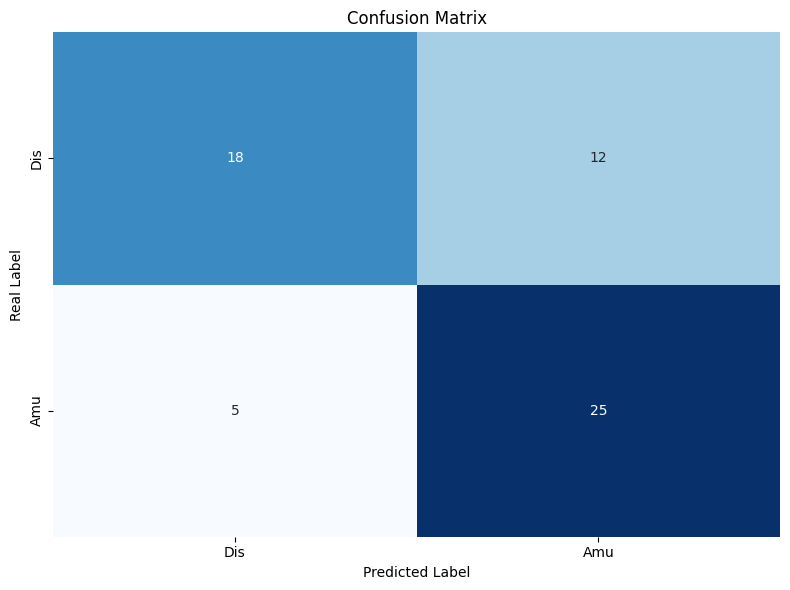

图表已保存为sub2_metrics_chart.png和sub2_confusion_matrix.png
分类器模型已保存至 /mnt/dataset0/xkp/closed-loop/server/data/sub2/emotion_classifier.pkl


<Figure size 1000x600 with 0 Axes>

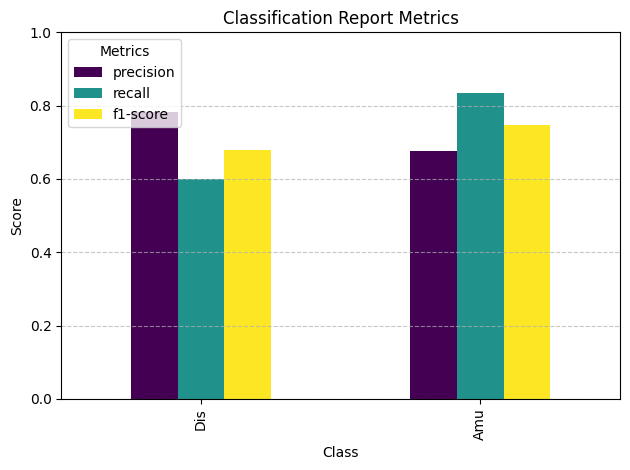

In [3]:
# 使用pandas生成报告并绘制图表
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)
class_names = ['Dis', 'Amu']  # 根据你的标签类型调整
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Real Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'sub{subject_id}_confusion_matrix.png')
plt.show()

# 2. 性能指标条形图
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_metrics = df_report.iloc[:-3]
df_metrics = df_metrics.rename(index={'0': 'Dis', '1': 'Amu'})

metrics = ['precision', 'recall', 'f1-score']
df_plot = df_metrics[metrics]

plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', colormap='viridis')
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.xlabel('Class')
plt.ylim(0, 1.0)
plt.legend(title='Metrics', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'sub{subject_id}_metrics_chart.png')
print(f"图表已保存为sub{subject_id}_metrics_chart.png和sub{subject_id}_confusion_matrix.png")

# 保存模型用于后续实验
import pickle
model_save_path = os.path.join(base_data_path, 'emotion_classifier.pkl')
with open(model_save_path, 'wb') as f:
    pickle.dump(clf, f)
print(f"分类器模型已保存至 {model_save_path}")

### 实时情绪分类测试

使用实时更新的 bar chart 显示被试情绪状态。

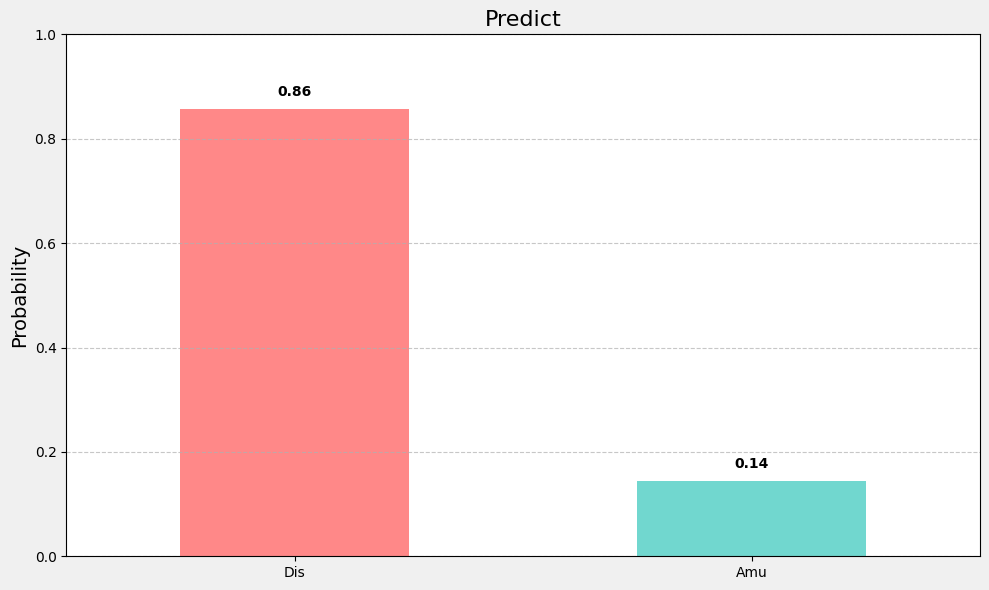

动画已保存为sub2_emotion_animation.gif


In [4]:
from matplotlib.animation import FuncAnimation
import random

# 设置绘图参数
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#f0f0f0')
ax.set_ylim(0, 1)
ax.set_xlim(-0.5, 1.5)

# 初始值
categories = ['Dis', 'Amu']
colors = ['#FF6B6B', '#4ECDC4']
probabilities = [0.5, 0.5]

# 创建条形图
bars = ax.bar(categories, probabilities, color=colors, width=0.5, alpha=0.8)

# 添加概率文本标签
prob_texts = []
for i, (bar, prob) in enumerate(zip(bars, probabilities)):
    text = ax.text(bar.get_x() + bar.get_width()/2, prob + 0.02,
                 f'{prob:.2f}', ha='center', va='bottom', fontweight='bold')
    prob_texts.append(text)
    
# 设置标题和标签
ax.set_title('Predict', fontsize=16)
ax.set_ylabel('Probability', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 要测试的 sample
test_indices = list(range(len(y_test)))
random.shuffle(test_indices)

# 更新函数，每一帧调用一次
def update(frame):
    # 每一帧分出一个样本做预测
    idx = test_indices[frame % len(test_indices)]
    X = features[idx:idx+1]
    
    proba = clf.predict_proba(X)[0]
    
    # 更新概率值
    probabilities[0] = proba[0]  # Dis概率
    probabilities[1] = proba[1]  # Amu概率
    
    # 更新条形高度
    for bar, prob in zip(bars, probabilities):
        bar.set_height(prob)
    
    # 更新文本标签
    for i, (text, prob) in enumerate(zip(prob_texts, probabilities)):
        text.set_text(f'{prob:.2f}')
        text.set_position((i, prob + 0.02))

    # 返回所有更新的元素
    return list(bars) + prob_texts

# 创建动画
ani = FuncAnimation(fig, update, frames=min(100, len(y_test)), interval=1000, blit=True)
                 
plt.tight_layout()
plt.show()

# 保存动画
from matplotlib.animation import PillowWriter
ani.save(f'sub{subject_id}_emotion_animation.gif', writer=PillowWriter(fps=1))
print(f"动画已保存为sub{subject_id}_emotion_animation.gif")